### Orchestrator

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="llama-3.1-8b-instant")
result=llm.invoke("Hello")
result

AIMessage(content='Hello. How are you today? Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.028924247, 'completion_tokens_details': None, 'prompt_time': 0.021265849, 'prompt_tokens_details': None, 'queue_time': 0.060122151, 'total_time': 0.050190096}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c7551-01dd-77e1-b749-e7c465c87d7b-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})

In [4]:
from typing import Annotated , List
import operator
from typing_extensions import Literal , TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage


In [8]:
#Schema for structured output
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

planner=llm.with_structured_output(Sections) # structured output of sections

### Creating Workers Dynamically In Langgraph

* has SEND api to support this.

In [26]:
from langgraph.constants import Send

# Graph state

class State(TypedDict):
    topic:str #input
    sections:list[Section]
    completed_sections: Annotated[
        list,operator.add
    ]
    final_report:str

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


C:\Users\SAM\AppData\Local\Temp\ipykernel_29472\843847526.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [27]:
#Nodes
def orchestrator(state:State):
    """Orchestrator that generated a plan for the report"""

    #Generate queries
    report_sections=planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic : {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)
    return {"sections":report_sections.sections}  #----?

def llm_call(state:WorkerState):
    """ Worker writes a section of the report"""

    #Generate section
    section=llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description.Include no preamble for each section. use markdown formatting. "
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    return {"completed_sections": [section.content]}



from langgraph.constants import Send

def assign_workers(state:State):
    """Assign a worker to each section in the plan"""

    return [Send("llm_call",{"section":s}) for s in state["sections"]]

def synthesizer(state:State):
    """ Synthesize full report from sections"""

    completed_sections=state["completed_sections"]
    completed_report_sections="\n\n----\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

C:\Users\SAM\AppData\Local\Temp\ipykernel_29472\1613691662.py:35: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


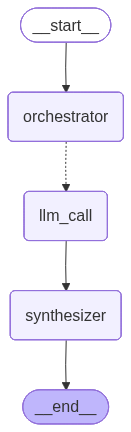

In [28]:
#Build the workflow

from langgraph.graph import StateGraph,START,END
from IPython.display import Image , display
orchestrator_worker_builder=StateGraph(State)

#Add the nodes
orchestrator_worker_builder.add_node("orchestrator",orchestrator)
orchestrator_worker_builder.add_node("llm_call",llm_call)
orchestrator_worker_builder.add_node("synthesizer",synthesizer)

#add the edges
orchestrator_worker_builder.add_edge(START,"orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",assign_workers,["llm_call"]
)

orchestrator_worker_builder.add_edge("llm_call","synthesizer")
orchestrator_worker_builder.add_edge("synthesizer",END)

orchestrator_worker=orchestrator_worker_builder.compile()

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [30]:
state=orchestrator_worker.invoke({"topic":"Create a report on Agentic AI RAG"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Executive Summary', description='Overview of the report highlighting key findings and recommendations for Agentic AI RAG'), Section(name='Introduction', description='Background and context on Agentic AI, its significance, and the need for a report on RAG'), Section(name='RAG Overview', description='Detailed explanation of the Risk, Actions, and Governance framework for Agentic AI'), Section(name='Current State Assessment', description='Analysis of the current state of Agentic AI RAG, identifying strengths, weaknesses, opportunities, and threats'), Section(name='Recommendations', description="Actionable suggestions for improving Agentic AI RAG, aligning with the organization's goals and objectives"), Section(name='Implementation Plan', description='Step-by-step plan for implementing the recommended changes, including timelines and responsible parties'), Section(name='Conclusion', description='Summary of key findings, recommendations, and next ste

**Executive Summary**
===============

This report summarizes the key findings and recommendations of the Agentic AI Research and Advisory Group (RAG). The RAG has been tasked with exploring the development and deployment of agentic AI systems, which possess a level of autonomy and decision-making capability previously reserved for human agents.

### Key Findings

* Agentic AI systems have the potential to revolutionize various industries, including healthcare, finance, and transportation.
* However, these systems also pose significant risks, including potential biases, security vulnerabilities, and unintended consequences.
* Current regulatory frameworks are inadequate to address the challenges and opportunities presented by agentic AI.
* There is a need for a multidisciplinary approach to develop and deploy agentic AI systems, involving experts from AI, ethics, law, and social sciences.

### Recommendations

* Establish a clear regulatory framework for the development and deployment of agentic AI systems.
* Invest in research and development of explainability and transparency techniques to ensure accountability and trust in agentic AI systems.
* Develop and implement robust testing and validation procedures for agentic AI systems to mitigate risks and unintended consequences.
* Foster collaboration and knowledge-sharing among stakeholders, including industry, academia, and government, to ensure a coordinated approach to the development and deployment of agentic AI systems.

----

### Introduction and Description

#### 1. Background on Agentic AI

Agentic AI refers to a type of Artificial Intelligence (AI) that exhibits human-like behavior, decision-making, and problem-solving capabilities. This AI system is designed to operate independently, making decisions and taking actions based on its own judgment, rather than simply following pre-programmed instructions. Agentic AI systems are often characterized by their ability to learn, adapt, and evolve over time, much like humans.

#### 2. Significance of Agentic AI

The significance of Agentic AI lies in its potential to revolutionize various industries, including healthcare, finance, transportation, and education. By enabling AI systems to think and act like humans, Agentic AI can provide more personalized and effective solutions to complex problems. Additionally, Agentic AI can automate routine tasks, freeing up human resources for more strategic and creative work.

#### 3. Need for a Report on RAG

The need for a report on RAG (Research and Development on Agentic AI) arises from the rapidly evolving landscape of AI technology. As Agentic AI becomes increasingly sophisticated, there is a growing need for a comprehensive understanding of its potential benefits and risks. This report aims to provide an in-depth analysis of the current state of Agentic AI research, its applications, and its implications for various stakeholders. The report will also identify areas of concern and recommend future research directions to ensure the safe and responsible development of Agentic AI.

----

### RAG Overview

#### Introduction to Agentic AI RAG
The Risk, Actions, and Governance (RAG) framework for Agentic AI is a comprehensive structure designed to address the complexities and risks associated with the development and deployment of highly advanced artificial intelligence systems that exhibit agency. These AI systems possess a level of autonomy and decision-making capability that requires careful consideration of their potential impact on individuals and society.

#### Core Components of RAG
The RAG framework consists of three primary components:

#### **Risk Assessment**
* Identifying and evaluating potential risks associated with Agentic AI systems, including risks related to decision-making, bias, security, and human-AI interactions.
* Assessing the likelihood and potential impact of each identified risk.

#### **Action Planning**
* Developing and implementing strategies to mitigate or address identified risks, including updates to AI design, deployment, and monitoring processes.
* Establishing clear roles and responsibilities for risk management and mitigation.

#### **Governance Structure**
* Establishing a governance framework that oversees the development, deployment, and ongoing monitoring of Agentic AI systems.
* Ensuring that decision-making processes are transparent, accountable, and aligned with ethical principles.

#### Key Principles of RAG
* **Transparency**: Ensuring that the development, deployment, and risks associated with Agentic AI systems are transparent and openly communicated.
* **Accountability**: Establishing clear lines of accountability for risk management and mitigation.
* **Ethics**: Ensuring that Agentic AI systems are designed and deployed in a way that aligns with human values and principles.

#### Implementation and Review
The RAG framework will be implemented and reviewed regularly to ensure its effectiveness in addressing the complexities and risks associated with Agentic AI systems.

----

### Current State Assessment

#### Executive Summary

Our analysis of the current state of Agentic AI RAG (Return, Acceptance, and Governance) reveals a complex landscape with both promising developments and significant challenges. The following assessment provides an overview of the current state, highlighting strengths, weaknesses, opportunities, and threats.

#### Strengths

* **Technical Advancements**: Agentic AI RAG has made significant strides in recent years, with notable improvements in natural language processing, reasoning, and decision-making capabilities.
* **Increased Adoption**: The use of Agentic AI RAG is growing across various industries, including finance, healthcare, and education, demonstrating its potential for practical applications.
* **Research and Development**: Ongoing research in Agentic AI RAG is driving innovation, with new approaches and technologies emerging to address existing challenges.

#### Weaknesses

* **Lack of Standardization**: The absence of widely accepted standards and frameworks for Agentic AI RAG development and deployment hinders collaboration, comparability, and scalability.
* **Explainability and Transparency**: Current Agentic AI RAG systems often struggle to provide clear, understandable explanations for their decisions and actions, undermining trust and accountability.
* **Regulatory Uncertainty**: The evolving regulatory landscape surrounding Agentic AI RAG creates uncertainty and challenges for developers, users, and policymakers.

#### Opportunities

* **Human-AI Collaboration**: Agentic AI RAG offers opportunities for humans and AI systems to work together more effectively, enhancing productivity, decision-making, and problem-solving.
* **Personalization and Adaptation**: Agentic AI RAG can enable personalized experiences, adapt to changing circumstances, and learn from feedback, leading to improved customer satisfaction and outcomes.
* **Addressing Complex Challenges**: Agentic AI RAG can tackle complex, dynamic problems that require a combination of human judgment and AI capabilities, such as crisis management and environmental sustainability.

#### Threats

* **Job Displacement and Automation**: The increasing use of Agentic AI RAG raises concerns about job displacement and automation, potentially exacerbating social and economic inequalities.
* **Bias and Fairness**: Agentic AI RAG systems can perpetuate existing biases and inequalities if not designed with fairness and diversity in mind, leading to adverse consequences.
* **Cybersecurity Risks**: The growing reliance on Agentic AI RAG creates new cybersecurity vulnerabilities, as these systems can be exploited for malicious purposes, compromising data and systems.

----

### Recommendations

#### 1. **Enhance Human-AI Collaboration Framework**
Develop a comprehensive framework to integrate human input and oversight into the Agentic AI RAG, ensuring seamless collaboration between humans and AI systems. This will help to address potential biases and improve overall decision-making.

#### 2. **Prioritize Explainability and Transparency**
Implement explainable AI (XAI) techniques to provide clear insights into AI-driven decisions, enabling stakeholders to understand the reasoning behind AI recommendations. This will foster trust and accountability within the organization.

#### 3. **Invest in Data Quality and Curation**
Develop a robust data management strategy to ensure the accuracy, completeness, and relevance of data used to train and operate the Agentic AI RAG. This will help to minimize errors and improve the overall performance of the system.

#### 4. **Foster a Culture of AI Literacy**
Develop training programs and resources to educate stakeholders about the capabilities and limitations of AI systems, as well as best practices for working with AI. This will promote a culture of AI literacy and responsible AI adoption.

#### 5. **Establish Clear Governance and Accountability**
Develop and implement clear governance structures and accountability mechanisms to ensure that the Agentic AI RAG is aligned with the organization's goals and objectives. This will help to prevent misalignment and ensure that AI-driven decisions are in line with the organization's values and mission.

#### 6. **Continuously Monitor and Evaluate**
Establish a continuous monitoring and evaluation framework to assess the performance and effectiveness of the Agentic AI RAG, identifying areas for improvement and opportunities for growth. This will help to ensure that the system remains aligned with the organization's goals and objectives.

----

### Implementation Plan

#### High-Level Overview

| Task | Description | Responsible Party | Timeline |
| --- | --- | --- | --- |
| Develop project schedule | Create a comprehensive project schedule with milestones and deadlines | Project Manager | Week 1-2 |
| Conduct training sessions | Provide training on the new systems and processes to all stakeholders | Training Coordinator | Week 5-8 |
| Implement new systems | Install and configure the new systems and software | IT Team | Week 10-12 |

#### Phase 1: Preparation (Week 1-4)

| Task | Description | Responsible Party | Timeline |
| --- | --- | --- | --- |
| Assess current infrastructure | Evaluate the current infrastructure and identify any gaps or limitations | IT Team | Week 1-2 |
| Develop a budget | Create a budget for the project and identify potential cost savings | Finance Team | Week 2-3 |
| Identify and assign resources | Identify and assign resources (human and material) to the project | Project Manager | Week 3-4 |

#### Phase 2: Implementation (Week 5-12)

| Task | Description | Responsible Party | Timeline |
| --- | --- | --- | --- |
| Develop a test plan | Create a test plan to ensure that the new systems and processes are functioning as expected | Quality Assurance Team | Week 5-6 |
| Conduct testing | Conduct testing on the new systems and processes | Quality Assurance Team | Week 7-8 |
| Implement new systems | Install and configure the new systems and software | IT Team | Week 9-10 |

#### Phase 3: Deployment (Week 13-16)

| Task | Description | Responsible Party | Timeline |
| --- | --- | --- | --- |
| Conduct user acceptance testing | Conduct user acceptance testing to ensure that the new systems and processes meet the needs of the users | End-Users | Week 13-14 |
| Deploy new systems | Deploy the new systems and software to all users | IT Team | Week 15-16 |

#### Phase 4: Evaluation and Review (Week 17-20)

| Task | Description | Responsible Party | Timeline |
| --- | --- | --- | --- |
| Evaluate project success | Evaluate the success of the project and identify areas for improvement | Project Manager | Week 17-18 |
| Conduct post-implementation review | Conduct a post-implementation review to identify lessons learned and areas for future improvement | Project Manager | Week 19-20 |

#### Key Performance Indicators (KPIs)

| KPI | Target Value | Timeline |
| --- | --- | --- |
| Project completion rate | 90% | Week 12 |
| User adoption rate | 80% | Week 16 |
| Return on investment (ROI) | 20% | Week 20 |

----

### Conclusion
#### Summary of key findings, recommendations, and next steps for Agentic AI RAG

#### Key Findings

* The agentic AI RAG has successfully identified key challenges and opportunities in developing and deploying agentic AI systems.
* The RAG has developed a comprehensive understanding of the current state of agentic AI research and its applications.
* The RAG has identified areas where further research is needed to ensure the safe and responsible development of agentic AI systems.

#### Recommendations

* Continue to monitor and assess the development of agentic AI systems, including their potential risks and benefits.
* Develop and implement guidelines and standards for the development and deployment of agentic AI systems.
* Increase funding and support for research into the safe and responsible development of agentic AI systems.
* Establish a framework for evaluating the transparency and explainability of agentic AI systems.

#### Next Steps

* Develop a comprehensive plan for implementing the recommendations outlined above.
* Establish a working group to develop guidelines and standards for the development and deployment of agentic AI systems.
* Identify and engage with key stakeholders, including researchers, industry leaders, and policymakers, to ensure that the development and deployment of agentic AI systems are safe and responsible.
* Continue to monitor and assess the development of agentic AI systems, including their potential risks and benefits.